In [ ]:
# olist_revenue_forecast
# Forecast monthly revenue (overall + top-5 categories) using supervised ML regressors

In [99]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [101]:
# -------------------------
# Config
# -------------------------
DATA_DIR = Path('/mnt/data')
HORIZON_MONTHS = 6  # forecast horizon
LAG_MONTHS = 3      # how many monthly lag features to create
TEST_MONTHS = 6     # hold-out test months

In [103]:
# -------------------------
# Helpers
# -------------------------

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

In [105]:
def create_supervised(df_ts, target_col='revenue', lags=LAG_MONTHS):
    # df_ts must have a DatetimeIndex with monthly frequency
    df = df_ts.copy()

In [107]:
def create_supervised(df_ts, target_col='revenue', lags=3):
    # Copy the input DataFrame to avoid modifying the original
    df = df_ts.copy()

    # Create lag features
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # Add time-based features
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Drop rows with NaNs created by lags
    df = df.dropna()

    # Split into features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

In [109]:
def train_and_forecast(X_train, y_train, X_test, models_dict):
    """Train models and produce predictions for X_test. Returns dict of predictions and fitted models."""
    preds = {}
    fitted = {}
    for name, model in models_dict.items():
        model.fit(X_train, y_train)
        preds[name] = model.predict(X_test)
        fitted[name] = model
    return preds, fitted

In [111]:
# -------------------------
# Load datasets
# -------------------------
customers = pd.read_csv("olist_customers_dataset.csv", encoding="latin1")
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv', encoding="latin1")
payments = pd.read_csv('olist_order_payments_dataset.csv')

In [112]:
orders_rename = orders.rename(
    columns={
        'order_purchase_timestamp': 'order_purchase_timestamp_orders',
        'order_status': 'order_status_orders'
    }
)

order_items = order_items.merge(
    orders_rename[['order_id', 'order_purchase_timestamp_orders', 'order_status_orders']],
    on='order_id',
    how='left'
)

In [113]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


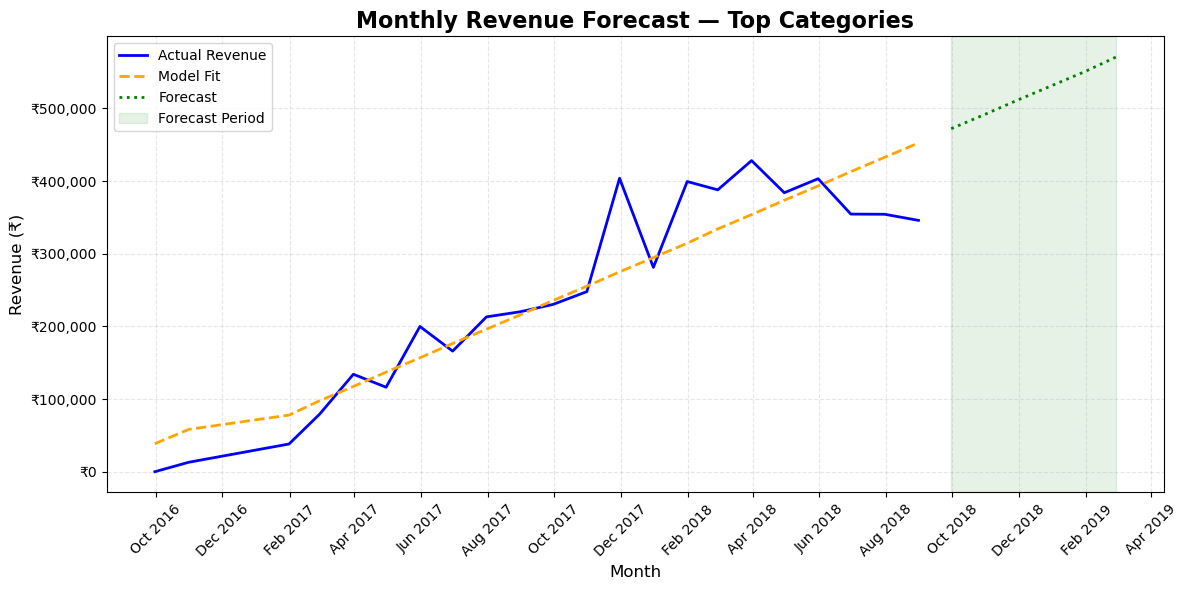

In [121]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# Plot setup
plt.figure(figsize=(12, 6))

# Actual Revenue (Blue)
plt.plot(monthly_revenue['month'], monthly_revenue['revenue'],
         label='Actual Revenue', color='blue', linewidth=2)

# Model Prediction for historical data (Orange dashed)
plt.plot(monthly_revenue['month'], monthly_revenue['predicted_revenue'],
         label='Model Fit', color='orange', linestyle='--', linewidth=2)

# Forecast for next 6 months (Green dotted)
plt.plot(forecast_df['month'], forecast_df['predicted_revenue'],
         label='Forecast', color='green', linestyle=':', linewidth=2)

# Shade the forecast period
plt.axvspan(forecast_df['month'].min(), forecast_df['month'].max(),
            color='green', alpha=0.1, label='Forecast Period')

# Title & labels
plt.title("Monthly Revenue Forecast — Top Categories", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# Currency formatting
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))

# Grid
plt.grid(alpha=0.3, linestyle='--')

# Legend
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [123]:
# Show top 5 category names, cleaned
def clean_category_name(name):
    return name.replace("_", " ").title()

top_categories_clean = [clean_category_name(cat) for cat in top_categories]
print("Top 5 Categories:", ", ".join(top_categories_clean))

Top 5 Categories: Health Beauty, Watches Gifts, Bed Bath Table, Sports Leisure, Computers Accessories


In [135]:
print(products.columns)

Index(['product_id', 'product_category_name_English'], dtype='object')


Top 5 categories (by revenue):
['Health Beauty', 'Watches Gifts', 'Bed Bath Table', 'Sports Leisure', 'Computers Accessories']


C:\Users\Akshada\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Akshada\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Akshada\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Akshada\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Akshada\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


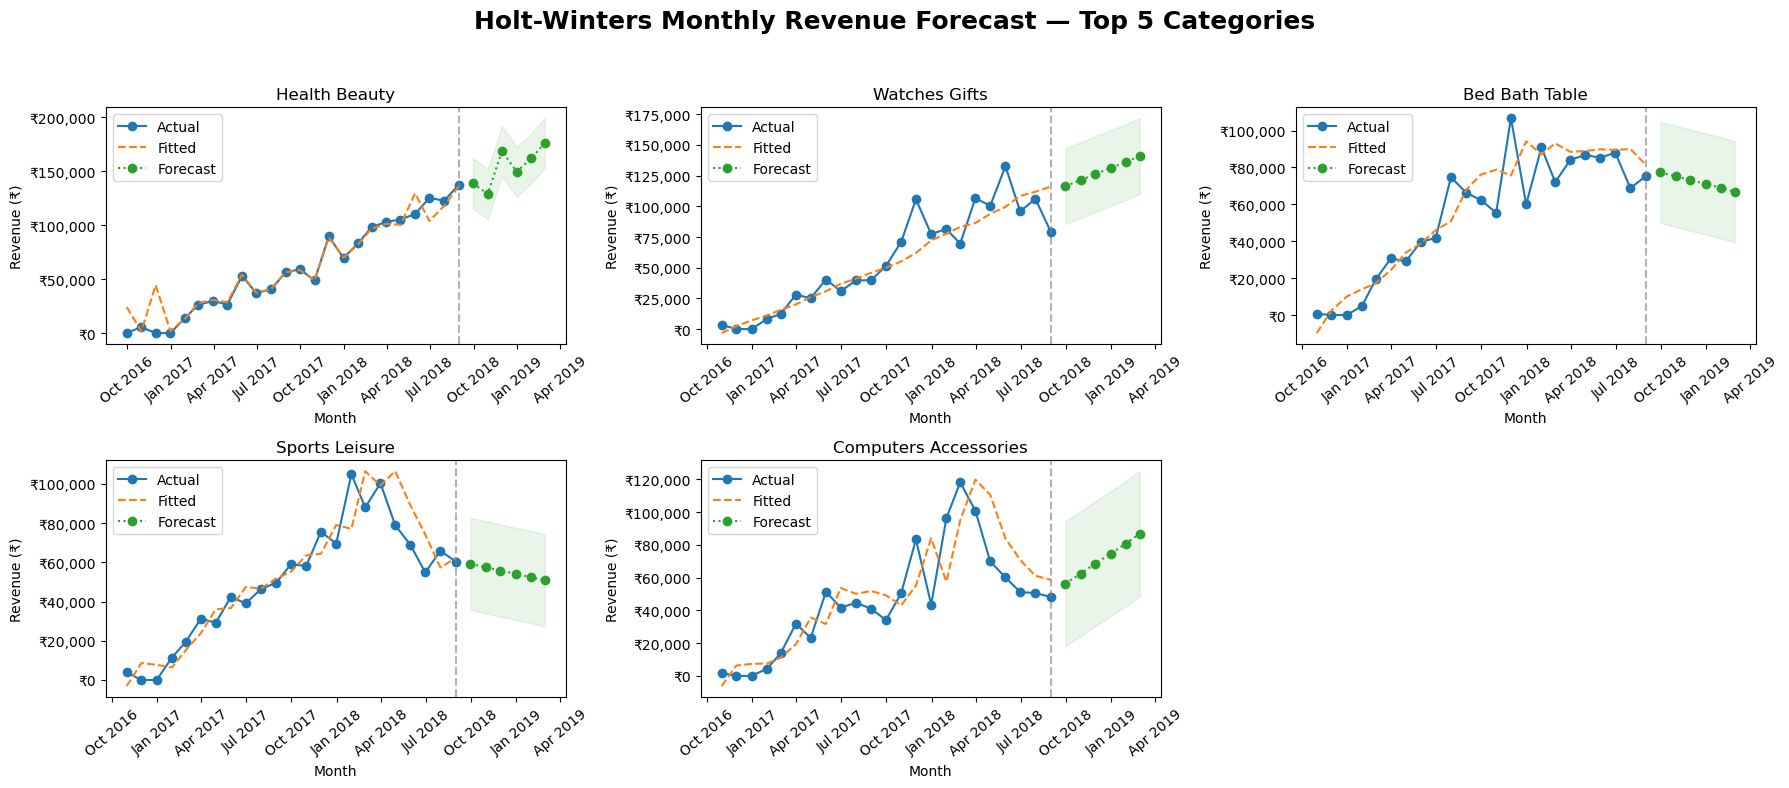


Forecast (6 months) — Health Beauty
     month forecast lower_95 upper_95
2018-09-30  138,796  115,638  161,954
2018-10-31  128,877  105,719  152,035
2018-11-30  168,647  145,489  191,805
2018-12-31  149,469  126,311  172,627
2019-01-31  162,020  138,862  185,178
2019-02-28  176,038  152,880  199,196

Forecast (6 months) — Watches Gifts
     month forecast lower_95 upper_95
2018-09-30  116,447   85,600  147,294
2018-10-31  121,355   90,509  152,202
2018-11-30  126,264   95,417  157,111
2018-12-31  131,172  100,325  162,019
2019-01-31  136,080  105,233  166,927
2019-02-28  140,989  110,142  171,835

Forecast (6 months) — Bed Bath Table
     month forecast lower_95 upper_95
2018-09-30   77,302   49,885  104,718
2018-10-31   75,214   47,798  102,631
2018-11-30   73,127   45,710  100,544
2018-12-31   71,040   43,623   98,456
2019-01-31   68,952   41,535   96,369
2019-02-28   66,865   39,448   94,281

Forecast (6 months) — Sports Leisure
     month forecast lower_95 upper_95
2018-09-30   5

In [139]:
# Holt-Winters Forecast for Top-5 Categories with auto-handling for short series

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ---------- Load datasets ----------
customers = pd.read_csv("olist_customers_dataset.csv", encoding="latin1")
order_items = pd.read_csv("olist_order_items_dataset.csv", encoding="latin1")
orders = pd.read_csv("olist_orders_dataset.csv", encoding="latin1")
products = pd.read_csv("olist_products_dataset.csv", encoding="latin1")
sellers = pd.read_csv("olist_sellers_dataset.csv", encoding="latin1")
payments = pd.read_csv("olist_order_payments_dataset.csv", encoding="latin1")

# ---------- Normalize column names ----------
for df in [customers, order_items, orders, products, sellers, payments]:
    df.columns = df.columns.str.lower()

# ---------- Ensure we have timestamp ----------
date_cols = [c for c in orders.columns if ('purchase' in c) or ('timestamp' in c)]
orders = orders.rename(columns={date_cols[0]: 'order_purchase_timestamp'})
order_items = order_items.merge(orders[['order_id', 'order_purchase_timestamp']],
                                on='order_id', how='left')

# ---------- Merge category ----------
prod_cat_cols = [c for c in products.columns if 'product_category_name' in c]
products = products.rename(columns={prod_cat_cols[0]: 'product_category_name'})
order_items = order_items.merge(products[['product_id', 'product_category_name']],
                                on='product_id', how='left')

# ---------- Revenue ----------
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce').fillna(0.0)
order_items['freight_value'] = pd.to_numeric(order_items['freight_value'], errors='coerce').fillna(0.0)
order_items['revenue'] = order_items['price'] + order_items['freight_value']

# ---------- Clean datetime ----------
order_items['order_purchase_timestamp'] = pd.to_datetime(order_items['order_purchase_timestamp'], errors='coerce')
order_items = order_items.dropna(subset=['order_purchase_timestamp']).sort_values('order_purchase_timestamp')

# ---------- Top-5 categories ----------
top5 = (order_items.groupby('product_category_name')['revenue']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index
        .tolist())

def clean_name(n):
    return str(n).replace("_", " ").title()

print("Top 5 categories (by revenue):")
print([clean_name(x) for x in top5])

# ---------- Forecast ----------
n_forecast = 6
n_cols = 3
n_rows = int(np.ceil(len(top5) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

all_forecasts = {}

for i, cat in enumerate(top5):
    ax = axes[i]
    cat_label = clean_name(cat)
    
    s = (order_items[order_items['product_category_name'] == cat]
         .set_index('order_purchase_timestamp')
         .resample('M')['revenue']
         .sum()
         .asfreq('M')
         .fillna(0.0))
    
    if len(s) < 3 or s.sum() == 0:
        ax.text(0.5, 0.5, f"Not enough data for\n{cat_label}", ha='center', va='center', fontsize=12)
        ax.set_title(cat_label)
        continue

    try:
        if len(s) >= 24:
            model = ExponentialSmoothing(s, trend='add', seasonal='add', seasonal_periods=12)
        else:
            model = ExponentialSmoothing(s, trend='add', seasonal=None)
        
        res = model.fit(optimized=True)
        fitted = res.fittedvalues
        forecast = res.forecast(n_forecast)
        
        resid_std = (s - fitted).std(ddof=0)
        z = 1.96
        lower = forecast - z * resid_std
        upper = forecast + z * resid_std

        ax.plot(s.index, s, label='Actual', marker='o')
        ax.plot(fitted.index, fitted, label='Fitted', linestyle='--')
        ax.plot(forecast.index, forecast, label='Forecast', linestyle=':', marker='o', color='tab:green')
        ax.fill_between(forecast.index, lower, upper, color='tab:green', alpha=0.1)
        ax.axvline(x=s.index.max(), color='gray', linestyle='--', alpha=0.6)

        ax.set_title(cat_label)
        ax.set_xlabel('Month')
        ax.set_ylabel('Revenue (₹)')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        ax.tick_params(axis='x', rotation=40)
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))
        ax.legend()

        all_forecasts[cat_label] = pd.DataFrame({
            'month': forecast.index,
            'forecast': forecast.values,
            'lower_95': lower.values,
            'upper_95': upper.values
        })

    except Exception as e:
        ax.text(0.5, 0.5, f"Model failed for\n{cat_label}\n{str(e)}", ha='center', va='center', fontsize=10)
        ax.set_title(cat_label)

for j in range(len(top5), len(axes)):
    axes[j].axis('off')

plt.suptitle("Holt-Winters Monthly Revenue Forecast — Top 5 Categories", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---------- Print Forecast Tables ----------
for cat_label, df_fc in all_forecasts.items():
    print(f"\nForecast (6 months) — {cat_label}")
    print(df_fc.to_string(index=False,
                          formatters={'forecast': '{:,.0f}'.format,
                                      'lower_95': '{:,.0f}'.format,
                                      'upper_95': '{:,.0f}'.format}))
